images.shape: (106, 100, 100, 3)
poses.shape: (106, 4, 4)
focal: 138.88887889922103


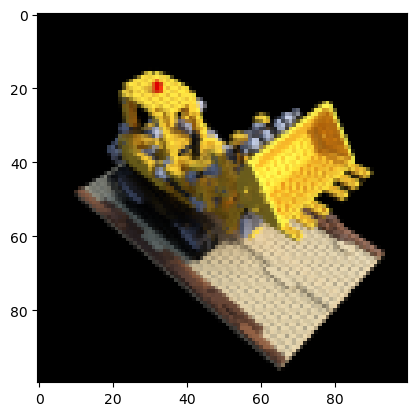

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(999)
np.random.seed(666)

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print("images.shape:", images.shape)
print("poses.shape:", poses.shape)
print("focal:", focal)

n_train = 100 # use n_train images for training

test_img, test_pose = images[101], poses[101]
images = images[:n_train]
poses = poses[:n_train]

plt.imshow(test_img)
plt.show()

In [2]:
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=60, input_ch_views=24, skip=4, use_view_dirs=True):
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skip = skip
        self.use_view_dirs = use_view_dirs

        self.net = nn.ModuleList([nn.Linear(input_ch, W)])
        for i in range(D-1):
            if i == skip:
                self.net.append(nn.Linear(W + input_ch, W))
            else:
                self.net.append(nn.Linear(W, W))

        self.alpha_linear = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        if use_view_dirs:
            self.proj = nn.Linear(W + input_ch_views, W // 2)
        else:
            self.proj = nn.Linear(W, W // 2)
        self.rgb_linear = nn.Linear(W // 2, 3)

    def forward(self, input_pts, input_views=None):
        h = input_pts.clone()
        for i, _ in enumerate(self.net):
            h = F.relu(self.net[i](h))
            if i == self.skip:
                h = torch.cat([input_pts, h], -1)

        alpha = F.relu(self.alpha_linear(h))
        feature = self.feature_linear(h)

        if self.use_view_dirs:
            h = torch.cat([feature, input_views], -1)

        h = F.relu(self.proj(h))
        rgb = torch.sigmoid(self.rgb_linear(h))

        return rgb, alpha

In [3]:
def PE(x, L):
  pe = []
  for i in range(L):
    for fn in [torch.sin, torch.cos]:
      pe.append(fn(2.**i * x))
  return torch.cat(pe, -1)

def sample_rays_np(H, W, f, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5+.5)/f, -(j-H*.5+.5)/f, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., None, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

def uniform_sample_point(tn, tf, N_samples, device):
    k = torch.rand([N_samples], device=device) / float(N_samples)
    pt_value = torch.linspace(0.0, 1.0, N_samples + 1, device=device)[:-1]
    pt_value += k
    return tn + (tf - tn) * pt_value

def get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=.0, use_view=False):
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_d => tensor(Batch_Size, 3)
    # Run network
    pts_flat = torch.reshape(pts, [-1, 3])
    pts_flat = PE(pts_flat, L=10)
    dir_flat = None
    if use_view:
        dir_flat = F.normalize(torch.reshape(rays_d.unsqueeze(-2).expand_as(pts), [-1, 3]), p=2, dim=-1)
        dir_flat = PE(dir_flat, L=4)

    rgb, sigma = net(pts_flat, dir_flat)
    rgb = rgb.view(list(pts.shape[:-1]) + [3])
    sigma = sigma.view(list(pts.shape[:-1]))

    # get the interval
    delta = z_vals[..., 1:] - z_vals[..., :-1]
    INF = torch.ones(delta[..., :1].shape, device=device).fill_(1e10)
    delta = torch.cat([delta, INF], -1)
    delta = delta * torch.norm(rays_d, dim=-1, keepdim=True)

    # add noise to sigma
    if noise_std > 0.:
        sigma += torch.randn(sigma.size(), device=device) * noise_std

    # get weights
    alpha = 1. - torch.exp(-sigma * delta)
    ones = torch.ones(alpha[..., :1].shape, device=device)
    weights = alpha * torch.cumprod(torch.cat([ones, 1. - alpha], dim=-1), dim=-1)[..., :-1]

    return rgb, weights


def render_rays(net, rays, bound, N_samples, device, noise_std=.0, use_view=False):
    rays_o, rays_d = rays
    bs = rays_o.shape[0]
    near, far = bound
    uniform_N, important_N = N_samples
    z_vals = uniform_sample_point(near, far, uniform_N, device)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_o, rays_d => tensor(Batch_Size, 3)

    rgb, weights = get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=noise_std, use_view=use_view)

    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, -1)
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

Process rays data!
There are 244 batches of rays and each batch contains 4096 rays


Epoch 1: 100%|██████████████████████████████████████| 244/244 [00:28<00:00,  8.49it/s, loss=0.01030]


PSNR=19.202917098999023


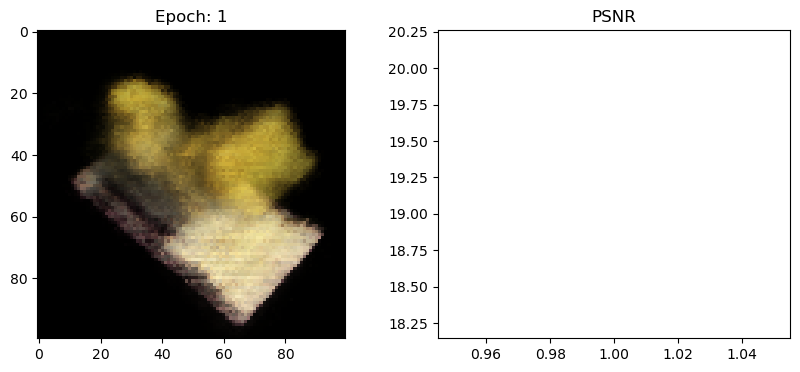

Epoch 2: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.87it/s, loss=0.00565]


PSNR=21.54256820678711


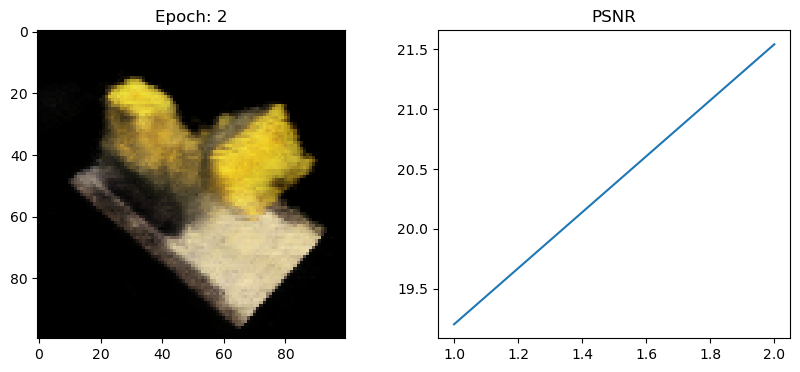

Epoch 3: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.84it/s, loss=0.00464]


PSNR=22.869291305541992


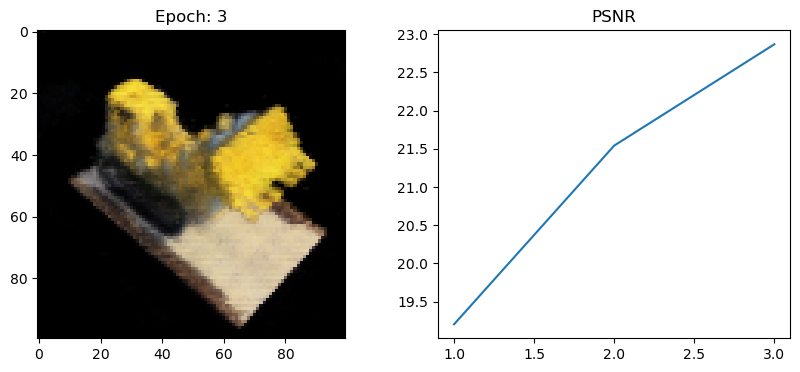

Epoch 4: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.83it/s, loss=0.00350]


PSNR=23.84335708618164


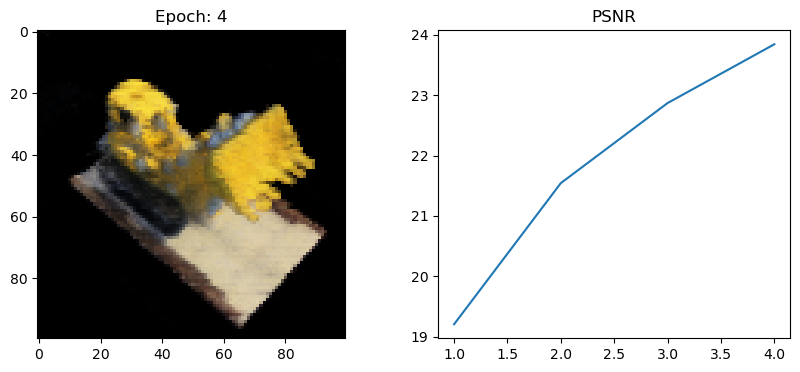

Epoch 5: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.83it/s, loss=0.00300]


PSNR=23.866708755493164


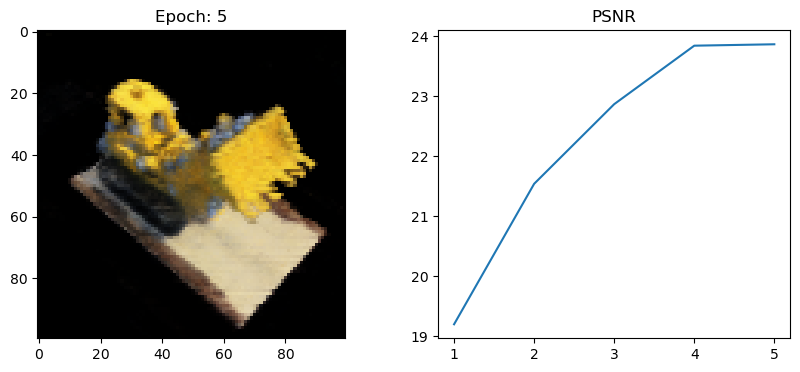

Epoch 6: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.85it/s, loss=0.00281]


PSNR=24.48153305053711


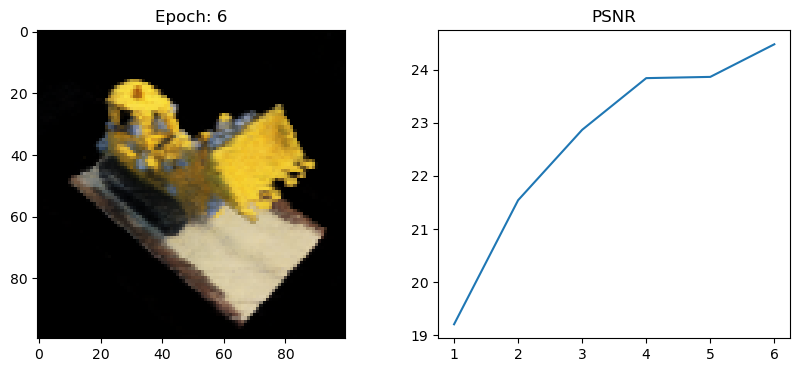

Epoch 7: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.85it/s, loss=0.00254]


PSNR=24.604244232177734


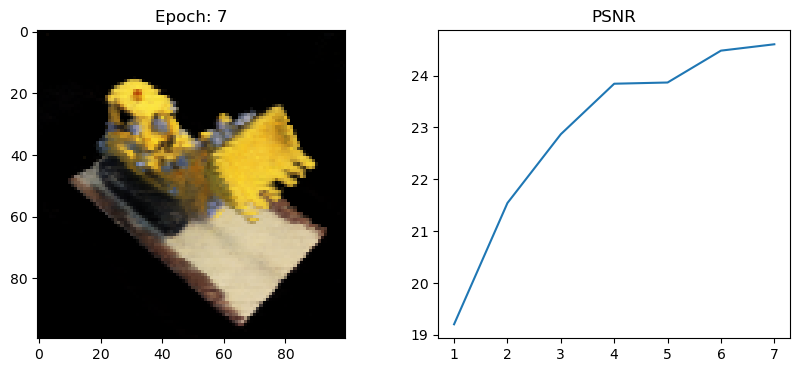

Epoch 8: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.87it/s, loss=0.00265]


PSNR=25.07396697998047


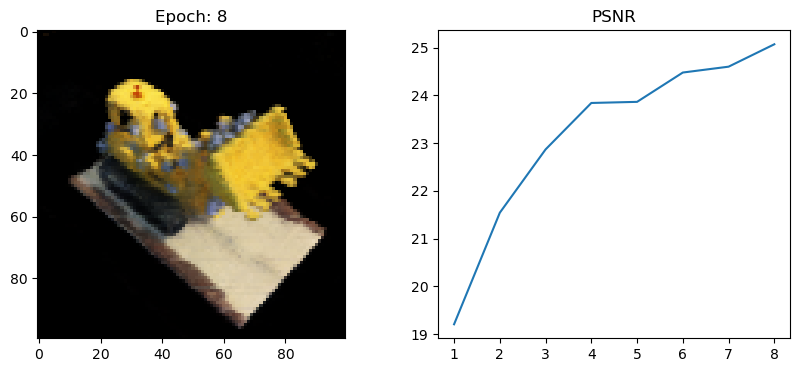

Epoch 9: 100%|██████████████████████████████████████| 244/244 [00:22<00:00, 10.89it/s, loss=0.00232]


PSNR=25.271244049072266


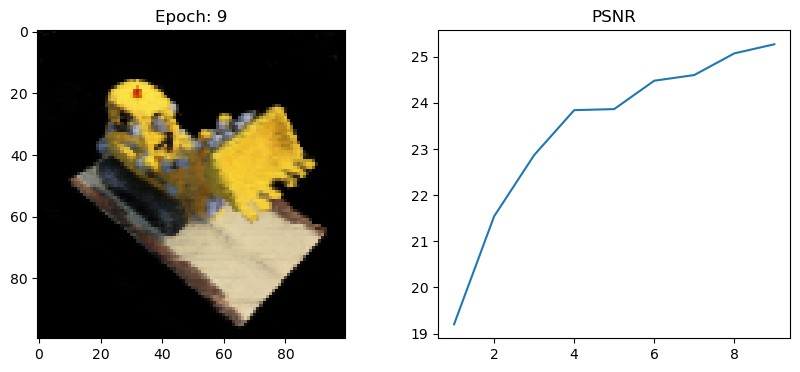

Epoch 10:  61%|██████████████████████▌              | 149/244 [00:13<00:08, 10.86it/s, loss=0.00238]

In [ ]:
print("Process rays data!")
rays_o_list = list()
rays_d_list = list()
rays_rgb_list = list()

for i in range(n_train):
    img = images[i]
    pose = poses[i]
    rays_o, rays_d = sample_rays_np(H, W, focal, pose)

    rays_o_list.append(rays_o.reshape(-1, 3))
    rays_d_list.append(rays_d.reshape(-1, 3))
    rays_rgb_list.append(img.reshape(-1, 3))

rays_o_npy = np.concatenate(rays_o_list, axis=0)
rays_d_npy = np.concatenate(rays_d_list, axis=0)
rays_rgb_npy = np.concatenate(rays_rgb_list, axis=0)
rays = torch.tensor(np.concatenate([rays_o_npy, rays_d_npy, rays_rgb_npy], axis=1), device=device)
# rays => tensor(N_rays, 9) => o+d+rgb

#############################
# training parameters
#############################
N = rays.shape[0]
Batch_size = 4096
iterations = N // Batch_size
print(f"There are {iterations} batches of rays and each batch contains {Batch_size} rays")

bound = (2., 6.)
N_samples = (64, None)
use_view = True
epoch = 10
psnr_list = []
e_nums = []

#############################
# test data
#############################
test_rays_o, test_rays_d = sample_rays_np(H, W, focal, test_pose)
test_rays_o = torch.tensor(test_rays_o, device=device)
test_rays_d = torch.tensor(test_rays_d, device=device)
test_rgb = torch.tensor(test_img, device=device)


#############################
# training
#############################
net = NeRF(use_view_dirs=use_view).to(device)
optimizer = torch.optim.Adam(net.parameters(), 5e-4)
mse = torch.nn.MSELoss()

for e in range(epoch):
    # create iteration for training
    rays = rays[torch.randperm(N), :]
    train_iter = iter(torch.split(rays, Batch_size, dim=0))

    # render + mse
    with tqdm(total=iterations, desc=f"Epoch {e+1}", ncols=100) as p_bar:
        for i in range(iterations):
            train_rays = next(train_iter)
            assert train_rays.shape == (Batch_size, 9)

            rays_o, rays_d, target_rgb = torch.chunk(train_rays, 3, dim=-1)
            rays_od = (rays_o, rays_d)
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)

            loss = mse(rgb, target_rgb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            p_bar.set_postfix({'loss': '{0:1.5f}'.format(loss.item())})
            p_bar.update(1)

    with torch.no_grad():
        rgb_list = list()
        for j in range(test_rays_o.shape[0]):
            rays_od = (test_rays_o[j], test_rays_d[j])
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
            rgb_list.append(rgb.unsqueeze(0))
        rgb = torch.cat(rgb_list, dim=0)
        loss = mse(rgb, torch.tensor(test_img, device=device)).cpu()
        psnr = -10. * torch.log(loss).item() / torch.log(torch.tensor([10.]))
        print(f"PSNR={psnr.item()}")
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb.cpu().detach().numpy())
        plt.title(f'Epoch: {e + 1}')
        plt.subplot(122)

        e_nums.append(e+1)
        psnr_list.append(psnr.numpy())
        plt.plot(e_nums, psnr_list)
        plt.title('PSNR')
        plt.show()

print('Done')